<h3><center>GRADCAM Motivation</center></h3> <img src="gradcam.png" width=300 height=300 /> <figcaption><center><i>A tale of two models</i></center></figcaption>

In [1]:
# Importing required libraries

import numpy as np
import os
import cv2
import random as rd
import tensorflow as tf
from tensorflow import keras
from matplotlib import image as im
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(5,4), 'figure.dpi':100})

In [3]:
# Loading all required models for GRAD-CAM

mymodel = keras.models.load_model('mymodel.h5')
model_builder = keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

In [4]:
# Dictionary containing names of all class labels

idx2lbl = {}

idx2lbl.update(dict.fromkeys([0, 4], 'Bacterial leaf blight'))    # Assigning same values to multiple keys
idx2lbl.update(dict.fromkeys([1, 5], 'Brown spot'))
idx2lbl.update(dict.fromkeys([2, 6], 'Healthy leaf'))
idx2lbl.update(dict.fromkeys([3, 7], 'Leaf smut'))

In [5]:
# Selecting random images from the directory

test1 = rd.choice(os.listdir('Bacterial leaf blight'))
test2 = rd.choice(os.listdir('Brown spot'))
test3 = rd.choice(os.listdir('Healthy leaf'))
test4 = rd.choice(os.listdir('Leaf smut'))

In [6]:
# Testing model on unseen images

files = []

for i in os.listdir('Unseen'):
    files.append(i)

In [7]:
test1 = './Bacterial leaf blight/' + test1 
test2 = './Brown spot/' + test2
test3 = './Healthy leaf/' + test3
test4 = './Leaf smut/' + test4
test5 = './Unseen/' + files[0]
test6 = './Unseen/' + files[1]
test7 = './Unseen/' + files[2]
test8 = './Unseen/' + files[3]

images = [test1, test2, test3, test4, test5, test6, test7, test8]

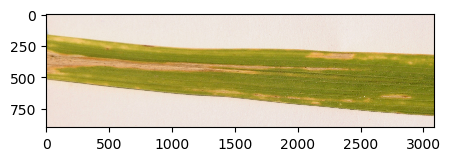

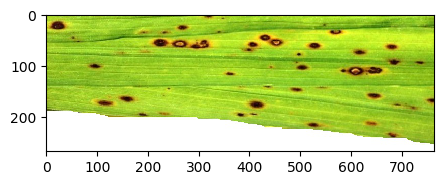

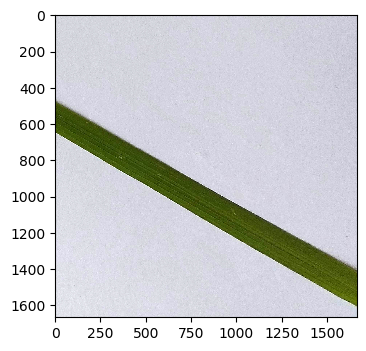

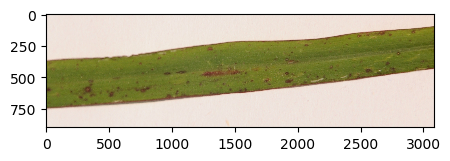

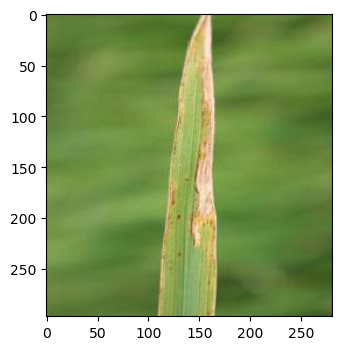

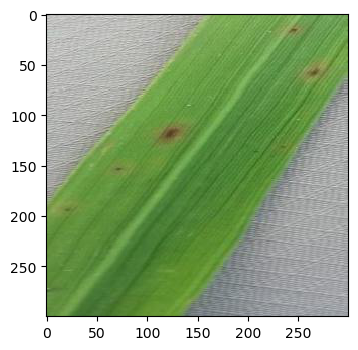

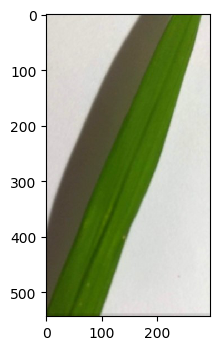

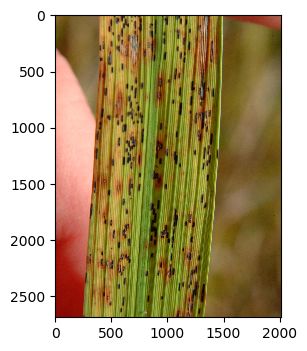

In [8]:
# Displaying the chosen images

for i in range(len(images)):
    img_path = images[i]
    img = im.imread(img_path)
    plt.imshow(img)
    plt.show()

In [9]:
# Helper function for processing images

def get_img_array(img_path, size):
    # 'img' is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # 'array' is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [10]:
# Function to create GRAD-CAM heatmap

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [11]:
# Loading model weights and modifying model architecture

model = model_builder(weights="imagenet")
model.layers[-1].activation = None

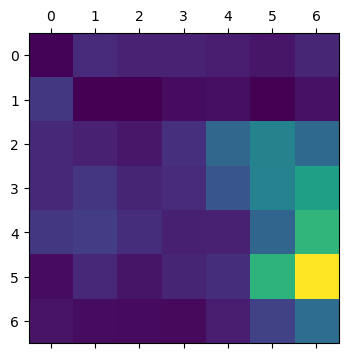

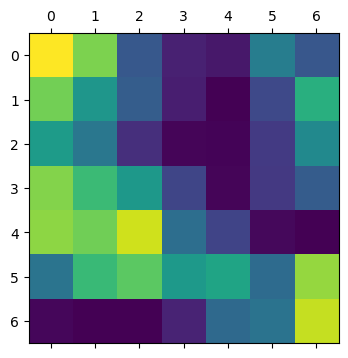

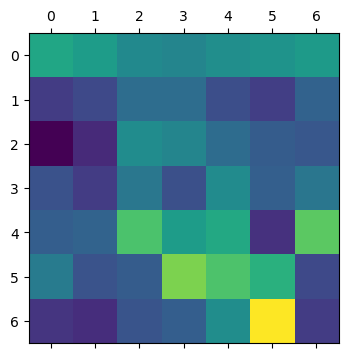

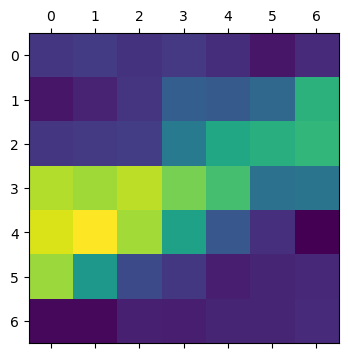

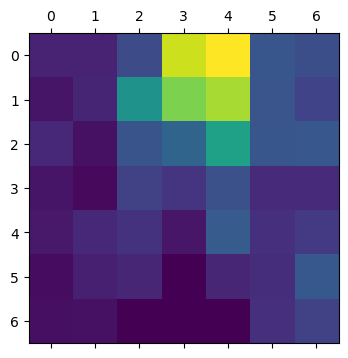

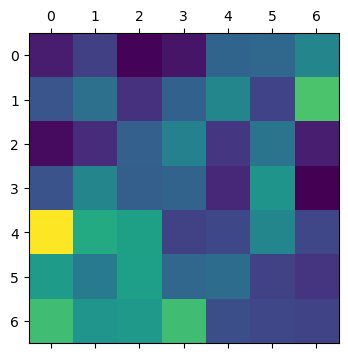

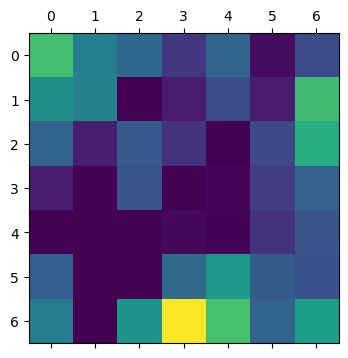

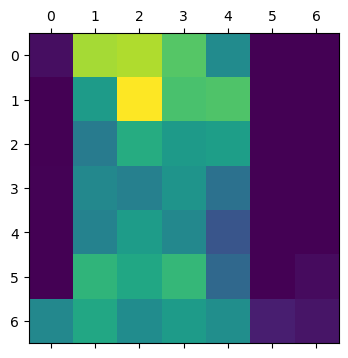

In [12]:
# Visualizing all generated heatmaps of the images

heatmaps = []

for i in range(len(images)):
    img_array = preprocess_input(get_img_array(images[i], size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)   # Generate class activation heatmap
    heatmaps.append(heatmap)
    plt.matshow(heatmap)
    plt.show()

In [13]:
# Function to superimpose heatmaps on original images

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    pic = im.imread(cam_path)
    plt.imshow(pic)
    plt.show()

In [14]:
# Initialising variable for model prediction

img_feature = np.zeros(shape = (len(images), 7, 7, 512))

In [15]:
# Feature extraction of selected images

vgg = model_builder(weights='imagenet', include_top=False)

for i in range(len(images)):
    img_path = images[i]
    img = cv2.imread(img_path)
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg.predict(img_data)
    img_feature[i] = vgg16_feature
    
img_features_vec = np.reshape(img_feature, (len(images), 7 * 7 * 512))

In [16]:
preds = mymodel.predict(img_features_vec)

In [17]:
# Retrieving predicted class labels

predlabels = []

for i in range(len(images)):
    x = np.argmax(preds[i])
    predlabels.append(x)

Original label: Bacterial leaf blight, Predicted: Bacterial leaf blight


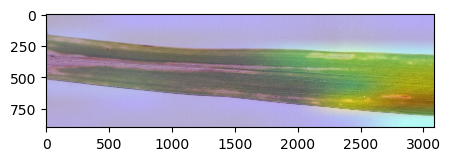

Original label: Brown spot, Predicted: Brown spot


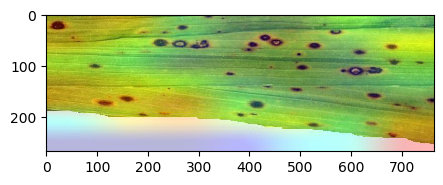

Original label: Healthy leaf, Predicted: Healthy leaf


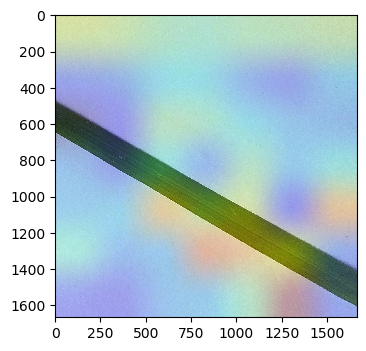

Original label: Leaf smut, Predicted: Leaf smut


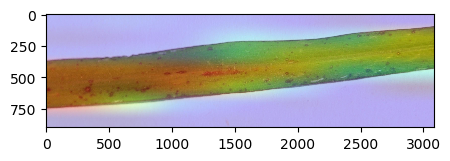

Original label: Bacterial leaf blight, Predicted: Leaf smut


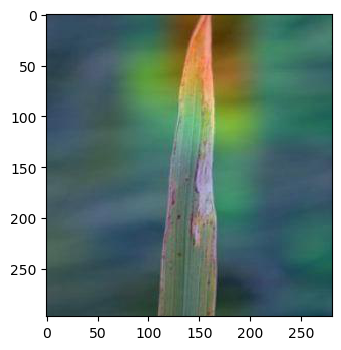

Original label: Brown spot, Predicted: Brown spot


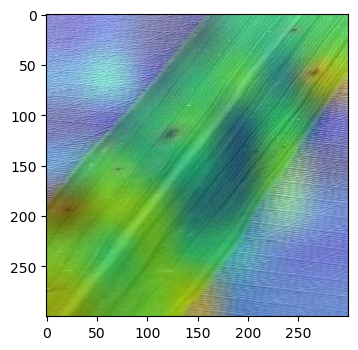

Original label: Healthy leaf, Predicted: Healthy leaf


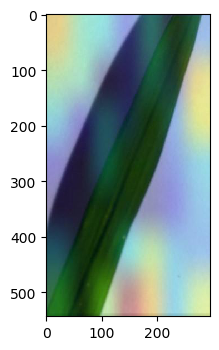

Original label: Leaf smut, Predicted: Leaf smut


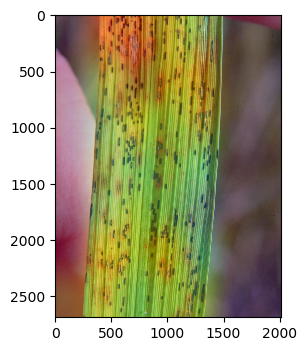

In [18]:
# Visualizing GRAD-CAM (superimposed images)

for i in range(len(images)):
    print('Original label: {}, Predicted: {}'.format(idx2lbl[i], idx2lbl[predlabels[i]])) 
    save_and_display_gradcam(images[i], heatmaps[i])